# PLAN

## Input

The dataset is available on the Kaggle platform, through this link: https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction 

Each row represents a customer and each column contains some attributes that describe that customer, in addition to her survey response, in which she mentioned interest or not in the new insurance product.

## Output

- Table with the k customers with the highest purchase propensity so that the team can make the calls;
- An API to sort new data

## Tasks

- Explore the Data using Statistical tools and tests in order to find data inconsistencies and treat possible missing data.

- Raise Hypotheses about the characteristics of legitimate and fraudulent transactions. Validate or refute these hypotheses through the data.

- Prepare the Data so that the Statistical Algorithms or Machine Learning are able to learn the task.

- Write various Classifier algorithms.

- Accounting for Machine Learning Model Performance and transforming it into Business Performance.

- Develop an API that returns a purchase “Propensity Score” for each customer, that is, a probability that the customer is interested in buying auto insurance.

- Create a README on how to interpret and use your solution.

- Write a Report, answering the business questions.

# IMPORTS

In [1]:
import pickle
import warnings
import gc

import pandas               as pd
import numpy                as np
import feather              as fd
import seaborn              as sns
import scikitplot           as skplt
import matplotlib.pyplot    as plt

from sklearn                 import ensemble           as en
from sklearn                 import neighbors          as nh
from sklearn                 import preprocessing      as pp
from sklearn                 import model_selection    as ms

from IPython.display         import Image
from IPython.core.display    import display, HTML
from sklearn.linear_model    import LogisticRegression
from lightgbm                import LGBMClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold , train_test_split
from sklearn.metrics         import precision_score
from sklearn.metrics         import recall_score

import random                as rd

warnings.filterwarnings('ignore')

/tmp/ipykernel_7083/1052747208.py:18: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display    import display, HTML


## Load Data

In [2]:
# carregando os csv
df_train_csv = pd.read_csv("../data/raw/train.csv")

In [3]:
# converte para o formato feather (mais rápido para ler e escrever no disco)
df_train_csv.to_feather("../data/raw/train.feather")

# apaga os dataframes em csv
del df_train_csv

# libera o espaço da memória
gc.collect();

In [4]:
# carrega os dados em feather para usar no projeto
df_insurance = pd.read_feather("../data/raw/train.feather")

In [5]:
# separa treino e teste
df_train, df_test = train_test_split(df_insurance, test_size= 0.25)

## Help Functions

### settings

In [6]:
def jupyter_settings():
    warnings.filterwarnings('ignore')
    #%matplotlib inline
    #%pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    #pd.options.display.max_columns = None
    #pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

### metrics

In [7]:
def precision_at_k(data, k=20000):
    
    # reset index
    data = data.reset_index(drop=True)

    # index
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k,'precision_at_k']


def recall_at_k(data, k=20000):
    
    # reset index
    data = data.reset_index(drop=True)

    # index
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k,'recall_at_k']

### cross validation

In [8]:
def cross_validation(model, model_name, x_train, y_train, num_folds , k=20000):
    # generate k-fold   
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)
    
    # save k-fold's prediction
    precisionatk_list_cv = []
    recallatk_list_cv = []

    for train_cv, val_cv in kfold.split(x_train, y_train):
    
        # get fold
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        # model definition
        model_fold = model

        # training model
        model_fold.fit(x_train_fold, y_train_fold)

        # prediction
        y_pred_fold = model_fold.predict_proba(x_val_fold)

        ## precision @K and recall @K
        # size of true values from target dataset
        k_size = k

        # add y_val to data to create score metrics 
        x_val_fold['response'] = y_val_fold.copy()

        # propensity score
        x_val_fold['propensity_score'] = y_pred_fold[:, 1].tolist()
        
        # sorted
        x_val_fold = x_val_fold.sort_values(by='propensity_score', ascending=False)

        # compute precision at k
        precisionatk_cv = precision_at_k(x_val_fold, k=k_size)
        precisionatk_list_cv.append(precisionatk_cv)
        
        # compute recall at k
        recallatk_cv = recall_at_k(x_val_fold, k=k_size)
        recallatk_list_cv.append(recallatk_cv)
        
    
    precision_at_k_cv_mean = np.mean(precisionatk_list_cv)
    precision_at_k_cv_std = np.std(precisionatk_list_cv)
    
    recall_at_k_cv_mean = np.mean(recallatk_list_cv)
    recall_at_k_cv_std = np.std(recallatk_list_cv)
         
    return pd.DataFrame({'Model': model_name , 
                                      'Precision@k_CV': precision_at_k_cv_mean,
                                      'CV_STD': precision_at_k_cv_std,
                                      'Recall@k_CV': recall_at_k_cv_mean,
                                      'CV_STD_Recall': recall_at_k_cv_std}, index=[0])

# DATA DESCRIPTION

In [9]:
df1 = df_train.copy()

## Info

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285831 entries, 139088 to 266779
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    285831 non-null  int64  
 1   gender                285831 non-null  object 
 2   age                   285831 non-null  int64  
 3   region_code           285831 non-null  float64
 4   policy_sales_channel  285831 non-null  float64
 5   driving_license       285831 non-null  int64  
 6   vehicle_age           285831 non-null  object 
 7   vehicle_damage        285831 non-null  object 
 8   previously_insured    285831 non-null  int64  
 9   annual_premium        285831 non-null  float64
 10  vintage               285831 non-null  int64  
 11  response              285831 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 28.3+ MB


## Dimension

In [11]:
print('Raws: {}'.format(df1.shape[0]))
print('Cols: {}'.format(df1.shape[1]))

Raws: 285831
Cols: 12


## CheckNA

In [12]:
df1.isnull().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## Description columns

- id : Unique ID for the customer
- Gender: Gender of the customer
- Age: Age of the customer
- Driving_License: 0 : Customer does not have DL, 1 : Customer already has DL
- Region_Code: Unique code for the region of the customer
- Previously_Insured: 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
- Vehicle_Age: Age of the Vehicle
- Vehicle_Damage: 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
- Annual_Premium: The amount customer needs to pay as premium in the year
- PolicySalesChannel: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
- Vintage: Number of Days, Customer has been associated with the company
- Response: 1 : Customer is interested, 0 : Customer is not interested

## Data Descriptive

In [13]:
# create dataframe with specific types
num_atributtes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64'])

### numeric attributes

In [14]:
att_num = num_atributtes.describe().T
att_num['skew'] = num_atributtes.apply( lambda x: x.skew() ).values
att_num['kurtosis'] = num_atributtes.apply( lambda x: x.kurtosis() ).values
att_num

count           mean            std     min      25%       50%       75%       max       skew    kurtosis
id                    285831.0  190445.514395  110023.294985     1.0  95251.5  190363.0  285675.5  381109.0   0.001508   -1.199736
age                   285831.0      38.812186      15.502746    20.0     25.0      36.0      49.0      85.0   0.672865   -0.563422
region_code           285831.0      26.380896      13.235890     0.0     15.0      28.0      35.0      52.0  -0.114901   -0.871102
policy_sales_channel  285831.0     112.086310      54.185290     1.0     29.0     136.0     152.0     163.0  -0.901991   -0.967083
driving_license       285831.0       0.997873       0.046072     0.0      1.0       1.0       1.0       1.0 -21.613047  465.127065
previously_insured    285831.0       0.458589       0.498283     0.0      0.0       0.0       1.0       1.0   0.166215   -1.972386
annual_premium        285831.0   30551.596867   17260.741445  2630.0  24390.5   31650.0   39393.0  540165.0   1.800978   33.461312
vintage               285831.0     154.269061      83.668483    10.0     82.0     154.0     227.0     299.0   0.004446   -1.199812
response              285831.0       0.122104       0.327406     0.0      0.0       0.0       0.0       1.0   2.308443    3.328931

In [15]:
num_atributtes.hist(bins=25);

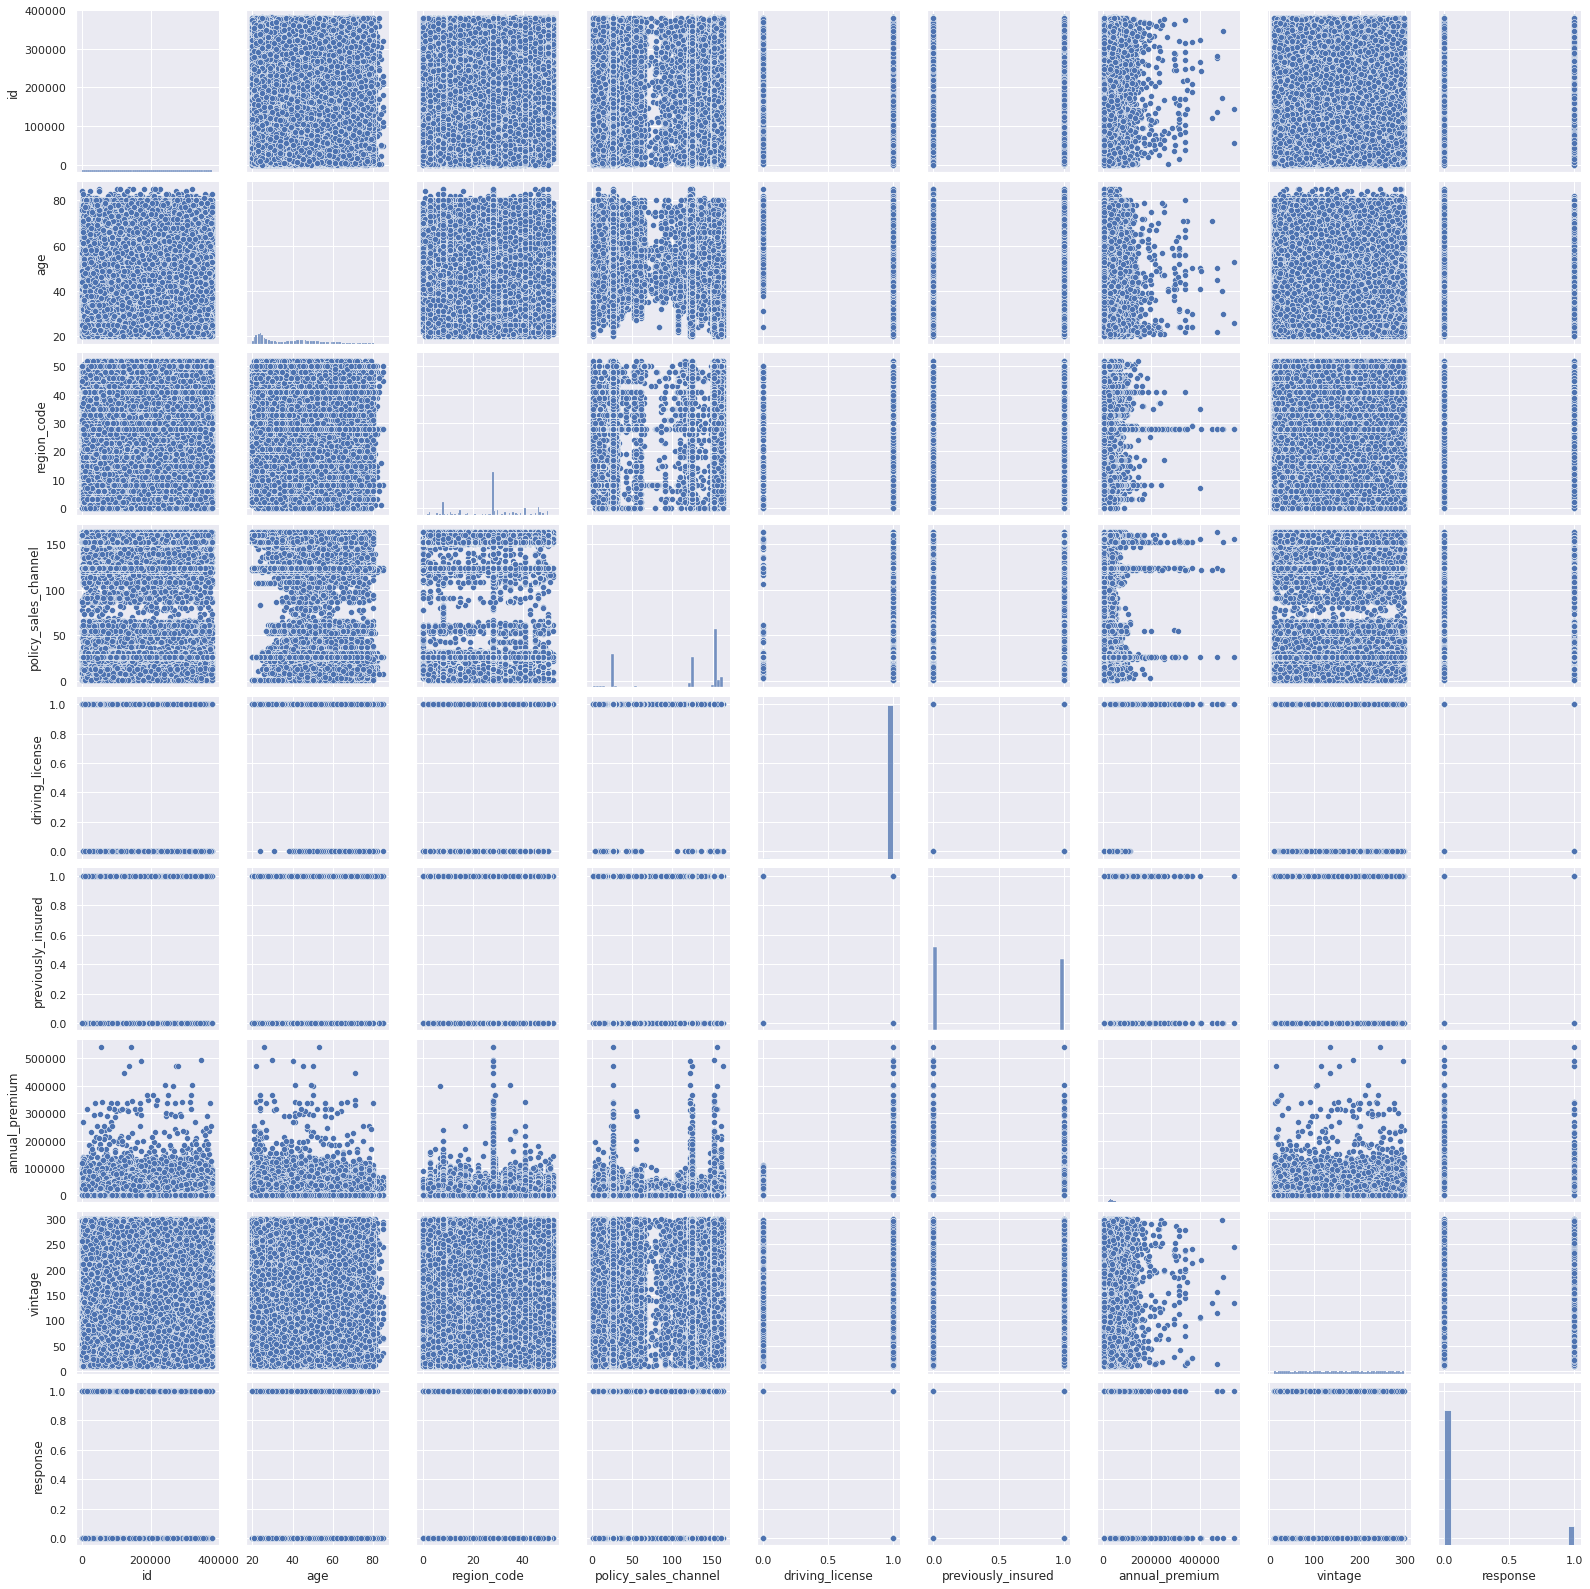

In [16]:
sns.pairplot(num_atributtes);

### categorical attributes

**GENDER** - **VEHICLE_DAMAGE** - **VEHICLE_AGE**

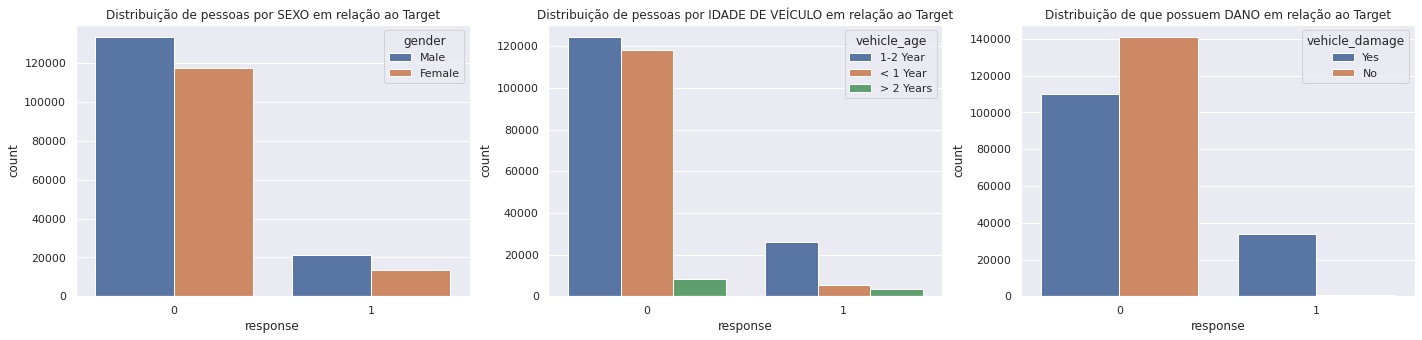

In [17]:
plt.figure(figsize=[24,5])
plt.subplot(1,3,1)
plt.title('Distribuição de pessoas por SEXO em relação ao Target')
sns.countplot(x='response', data=df1, hue='gender')
plt.subplot(1,3,2)
plt.title('Distribuição de pessoas por IDADE DE VEÍCULO em relação ao Target')
sns.countplot(x='response', data=df1, hue='vehicle_age')
plt.subplot(1,3,3)
plt.title('Distribuição de que possuem DANO em relação ao Target')
sns.countplot(x='response',data=df1, hue='vehicle_damage')
plt.show()

- **Comments:**
    * The percentage of men and women with an interest in insurance is proportional, with men having a slight advantage.
    * People interested in insurance have cars between 1 and 2 years old.
    * Only people who have had a car damage are interested in insurance

# FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

## Mind Map Hypothesis

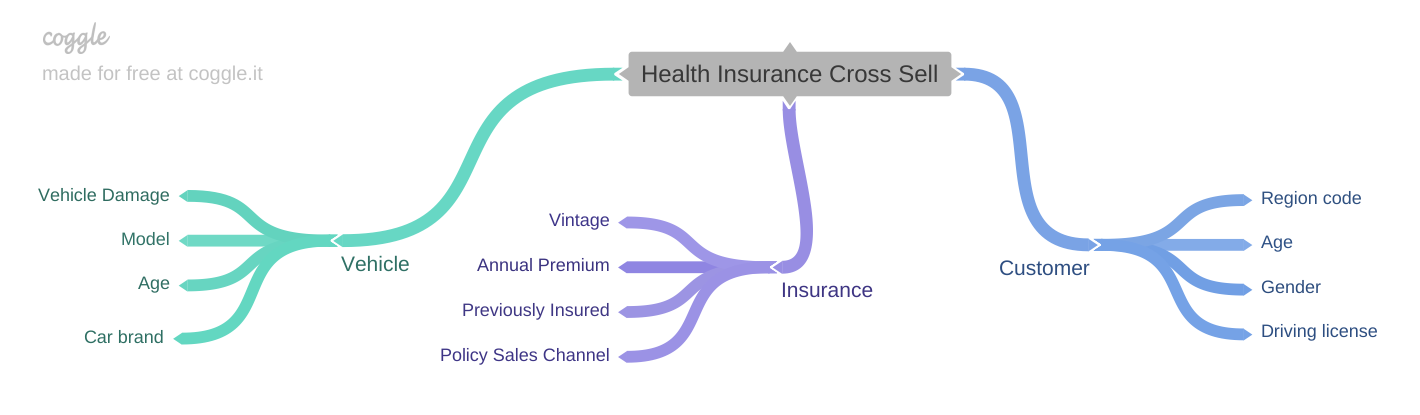

In [19]:
Image("../src/visualization/mapa_variaveis.png")

##  Hypothesis Creation

### Vehicle

- H1. Owners of damaged vehicles are more interested in purchasing insurance
- H2. New vehicles have more insurance than older vehicles

### Insurance

- H3. Customers who pay more for insurance annually have less interest in purchasing another

### Customer

- H4. Insurance for women is more expensive on average than for men
- H5. Older customers are more interested in "cross-selling"


## Feature engineering

In [20]:
# vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_two_years' if x == '> 2 Years' 
                                               else 'between_1_2_years' if x == '1-2 Year'   else 'below_1_year')

# vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)

# DATA FILTERING

In [21]:
df3 = df2.copy()

# EDA

In [22]:
df4 = df3.copy()

## Univariate analysis

### age

In [23]:
#age
sns.boxplot(x = 'response', y = 'age', data=df4);

In [24]:
aux = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux);
plt.show()

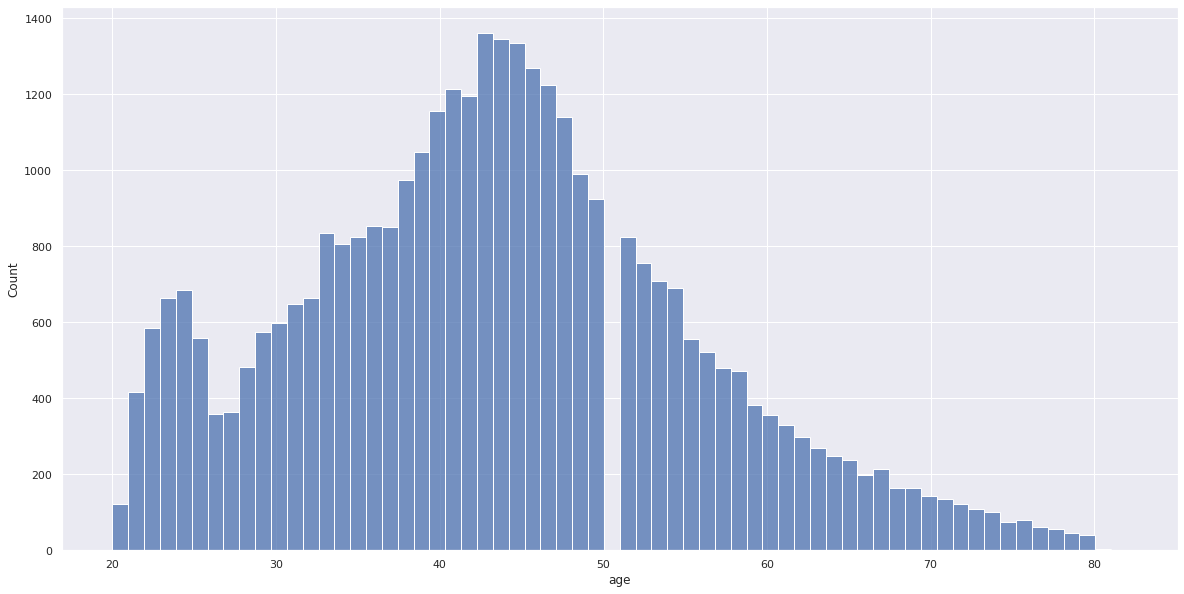

In [25]:
aux = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux);
plt.show()

### annual_premium

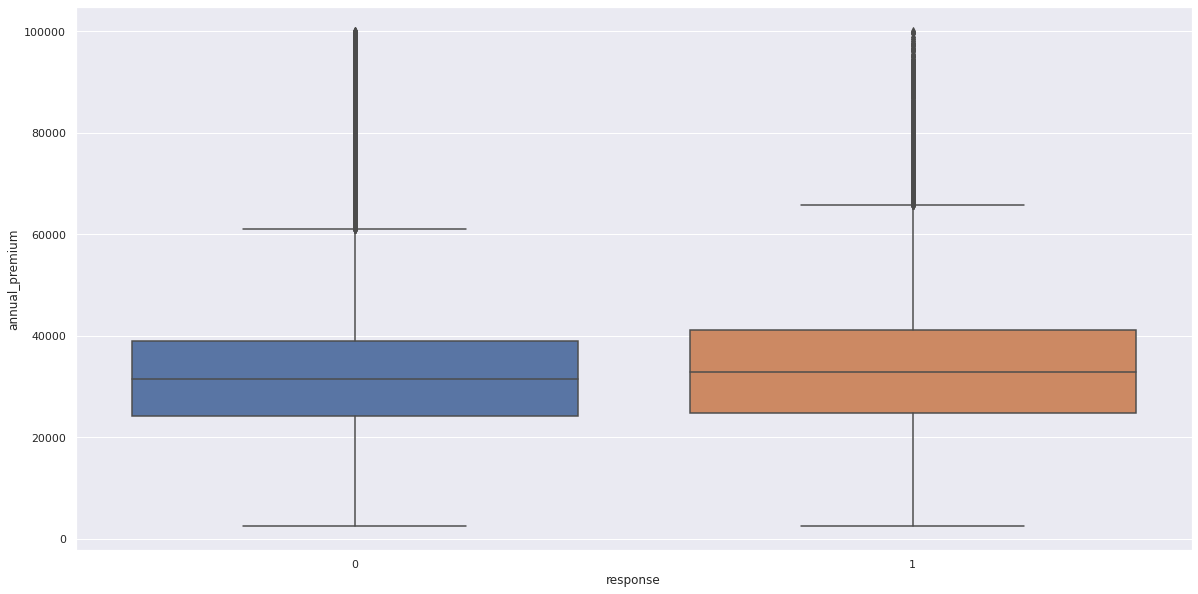

In [26]:
#annual_premium
aux_ap = df4.loc[df4['annual_premium'] < 100000]
sns.boxplot(x = 'response', y = 'annual_premium', data=aux_ap);
plt.show()

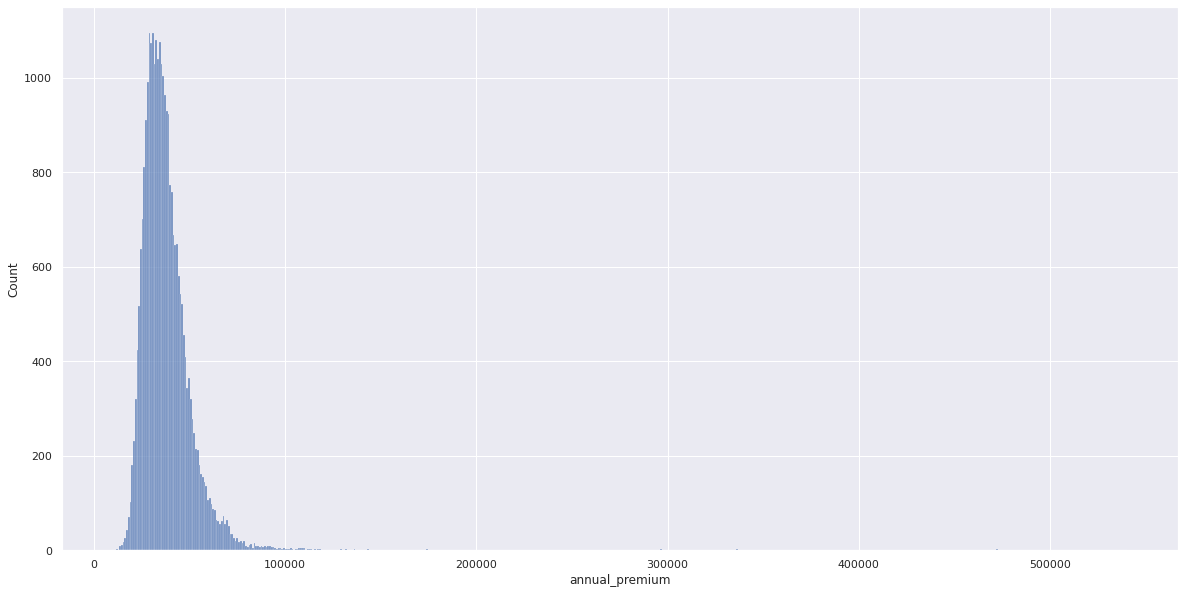

In [27]:
aux0 = df4.loc[(df4['response'] == 1) & (df4['annual_premium'] > 5000), 'annual_premium']
sns.histplot(aux0);
plt.show()

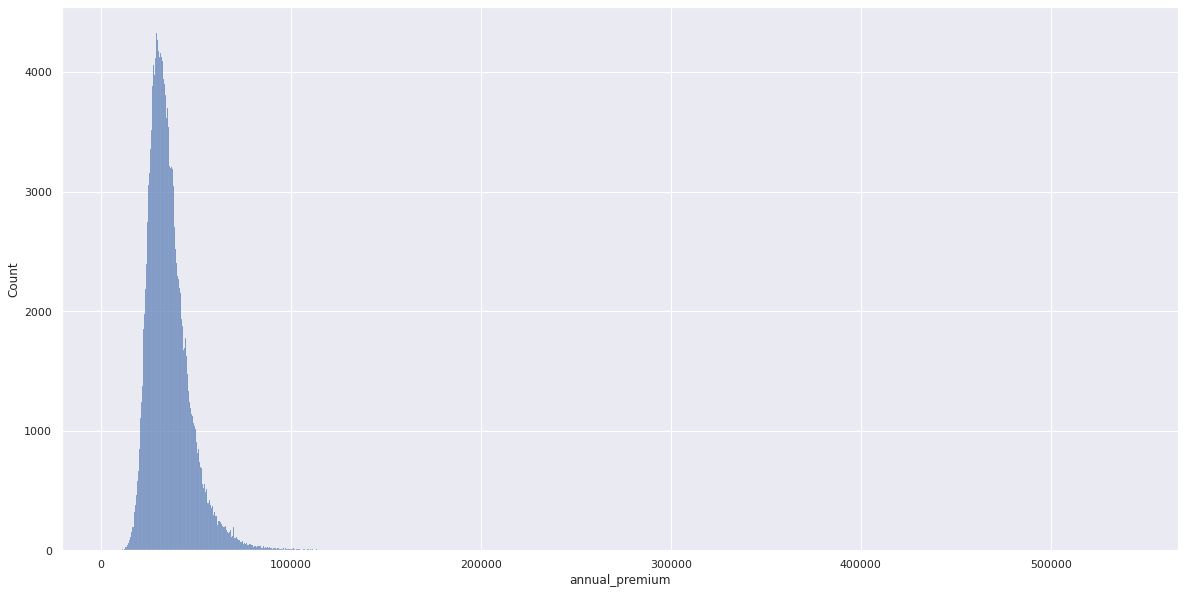

In [28]:
aux0 = df4.loc[(df4['response'] == 0) & (df4['annual_premium'] > 5000) , 'annual_premium']
sns.histplot(aux0);
plt.show()

### driving_license

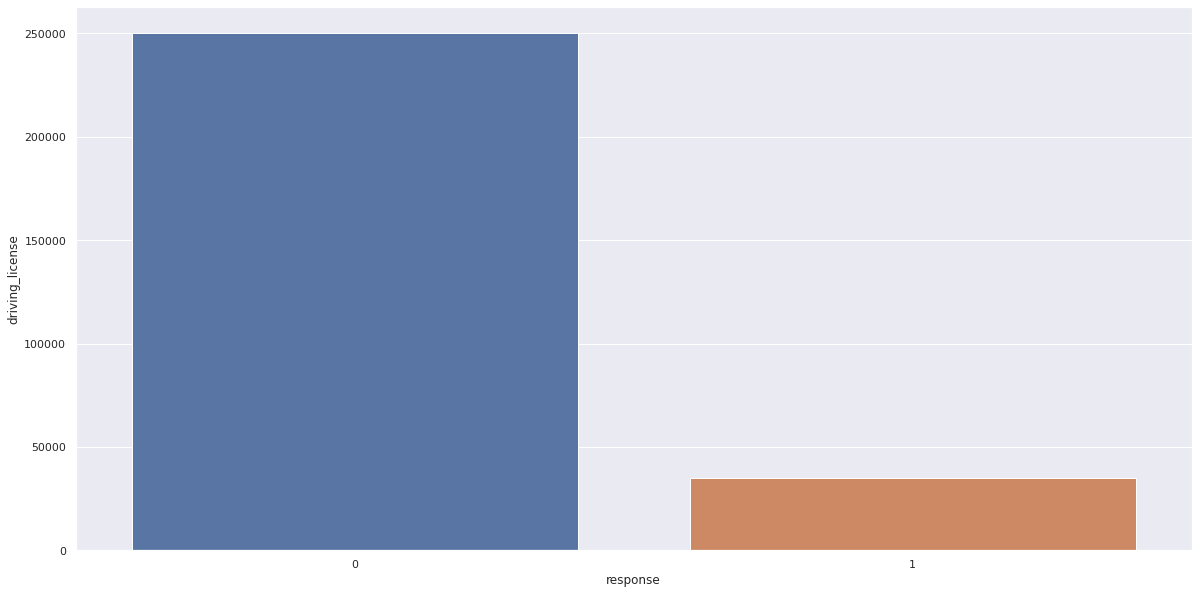

In [29]:
#driving_license

aux_dl = df4[['driving_license','response']].groupby('response').sum().reset_index()
sns.barplot(x='response',y='driving_license',data=aux_dl)
plt.show()

### region_code

In [30]:
aux = df4[['id','region_code','response']].groupby(['region_code','response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux)
plt.show()

### previously_insured

In [31]:
pd.crosstab(df4['previously_insured'],df4['response'])

response                 0      1
previously_insured               
0                   119979  34773
1                   130951    128

### gender

In [32]:
df4[['gender','response']].value_counts(normalize=True).reset_index()

gender  response         0
0    Male         0  0.466038
1  Female         0  0.411859
2    Male         1  0.074562
3  Female         1  0.047542

### policy_sales_channel

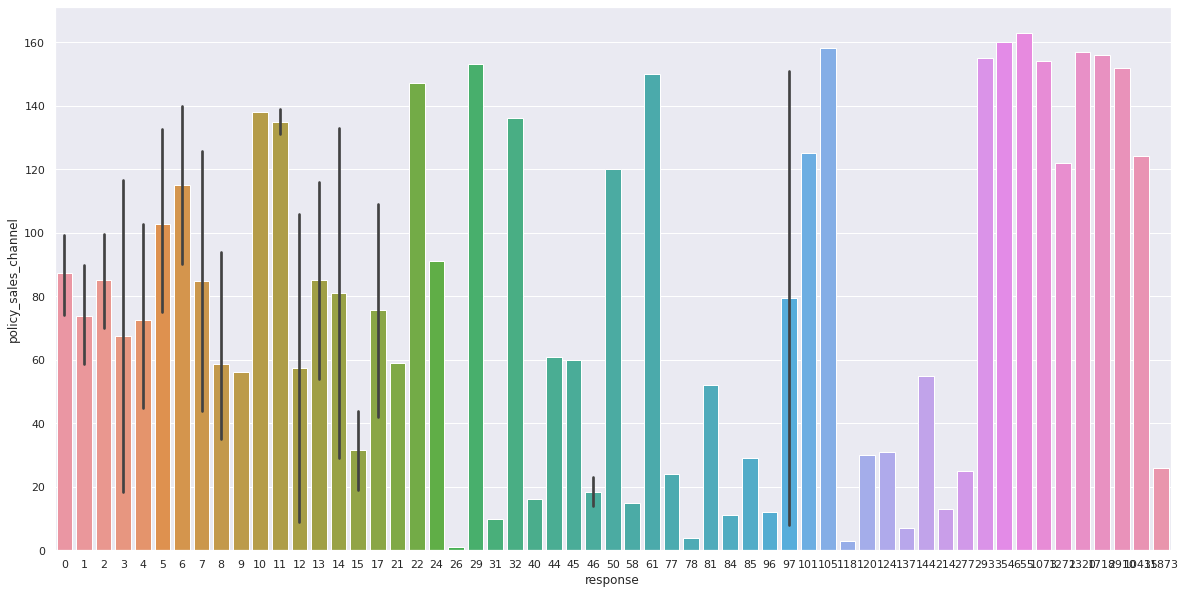

In [33]:
aux = df4[['policy_sales_channel','response']].groupby("policy_sales_channel").sum().reset_index()
sns.barplot(x="response", y="policy_sales_channel", data=aux);

### vehicle_age

In [34]:
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

vehicle_age  response         0
0  between_1_2_years         0  0.434669
1       below_1_year         0  0.413706
2  between_1_2_years         1  0.091036
3     over_two_years         0  0.029521
4       below_1_year         1  0.018885
5     over_two_years         1  0.012182

### vehicle_damage

In [35]:
df4[['vehicle_damage','response']].value_counts().reset_index()

vehicle_damage  response       0
0               0         0  140830
1               1         0  110100
2               1         1   34166
3               0         1     735

### vintage

In [36]:
df4[['vintage','response']]

vintage  response
139088      169         1
34603        56         1
6936        264         1
88146       100         0
261097      289         0
...         ...       ...
302747      258         0
128275       38         1
87501        50         0
248423       96         0
266779      172         0

[285831 rows x 2 columns]

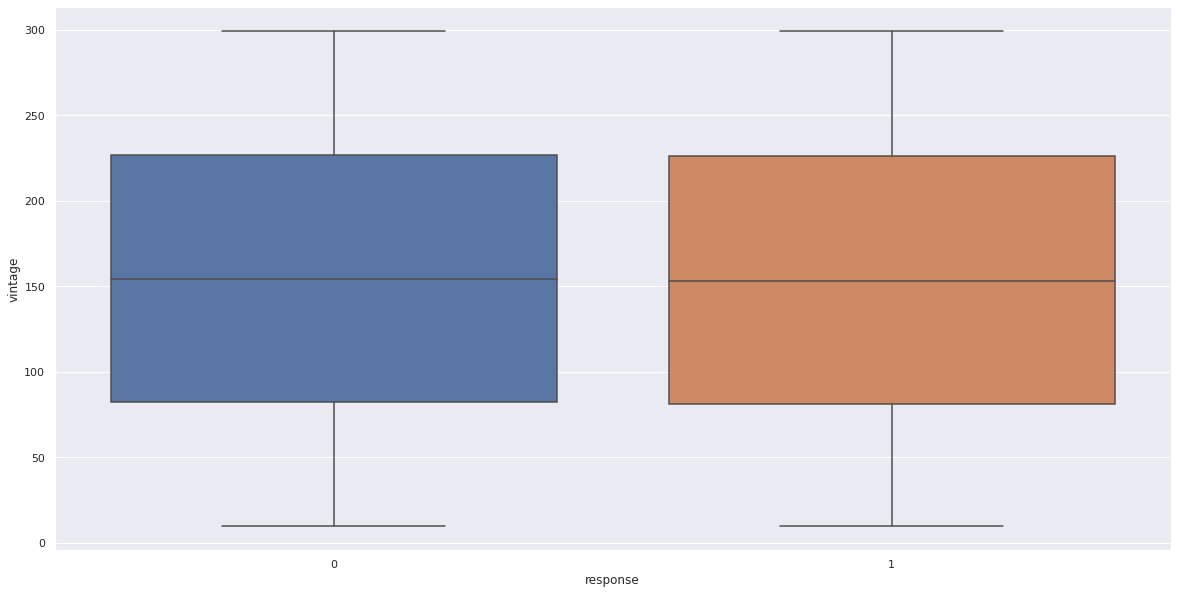

In [37]:
#vintage
aux_v = df4.loc[df4['vintage'] < 100000]
sns.boxplot(x = 'response', y = 'vintage', data=aux_v);
plt.show()

## Bivariate analysis

### H1. Owners of damaged vehicles are more interested in purchasing insurance
* TRUE

In [38]:
df4.head()

id  gender  age  region_code  policy_sales_channel  driving_license        vehicle_age  vehicle_damage  previously_insured  annual_premium  vintage  response
139088  139089    Male   44          7.0                  26.0                1  between_1_2_years               1                   0         33766.0      169         1
34603    34604  Female   33         28.0                 124.0                1       below_1_year               1                   0          2630.0       56         1
6936      6937    Male   44         28.0                  26.0                1  between_1_2_years               1                   0         66576.0      264         1
88146    88147    Male   21         36.0                 152.0                1       below_1_year               0                   1         29413.0      100         0
261097  261098    Male   23         12.0                  26.0                1       below_1_year               0                   1         21607.0      289         0

In [39]:
# auxiliar dataframes
aux_o = df4[df4["vehicle_damage"]== 0].groupby("response").count()
aux_1 = df4[df4["vehicle_damage"]== 1].groupby("response").count()

# plots
plt.figure(figsize=[20,6])
plt.subplot(1,2,1)
sns.barplot(x=aux_o.index,y="vehicle_damage", data=aux_o).set_title('Veículos que NÃO TIVERAM DANOS')
plt.xlabel("Interesse em adquirir novo seguro")
plt.ylabel("Quantidade de clientes")
plt.subplot(1,2,2)
sns.barplot(x=aux_o.index,y="vehicle_damage", data=aux_1).set_title('Veículos que TIVERAM ALGUM TIPO DE DANO')
plt.xlabel("Interesse em adquirir novo seguro")
plt.ylabel("Quantidade de clientes");

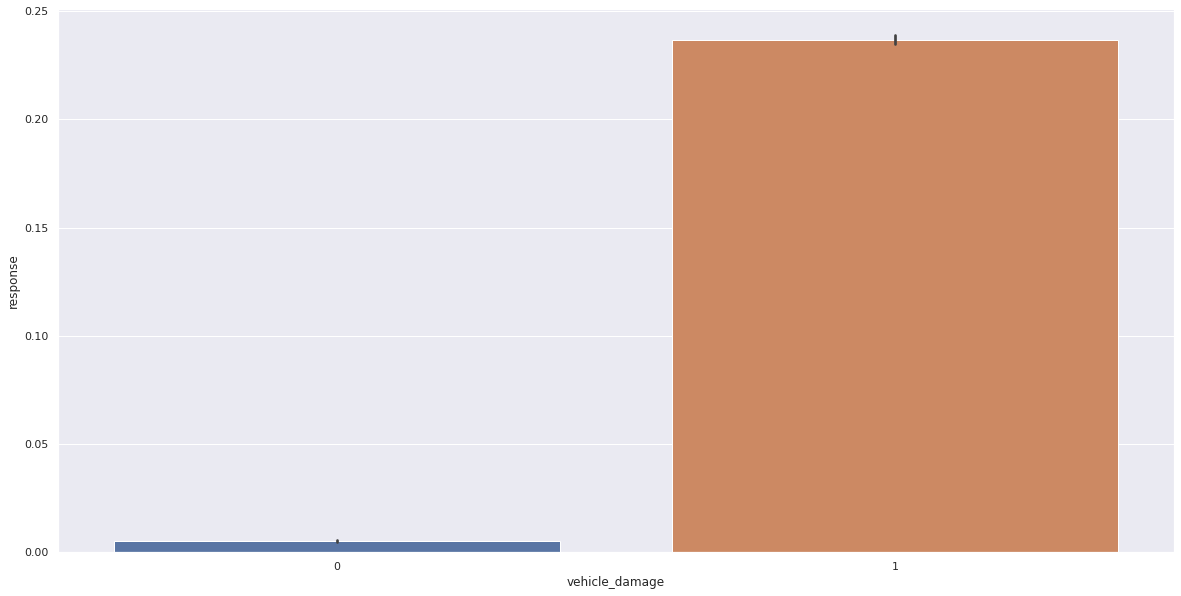

In [40]:
sns.barplot(x="vehicle_damage", y="response", data=df4);

### H2. New vehicles have more insurance than older vehicles
* TRUE

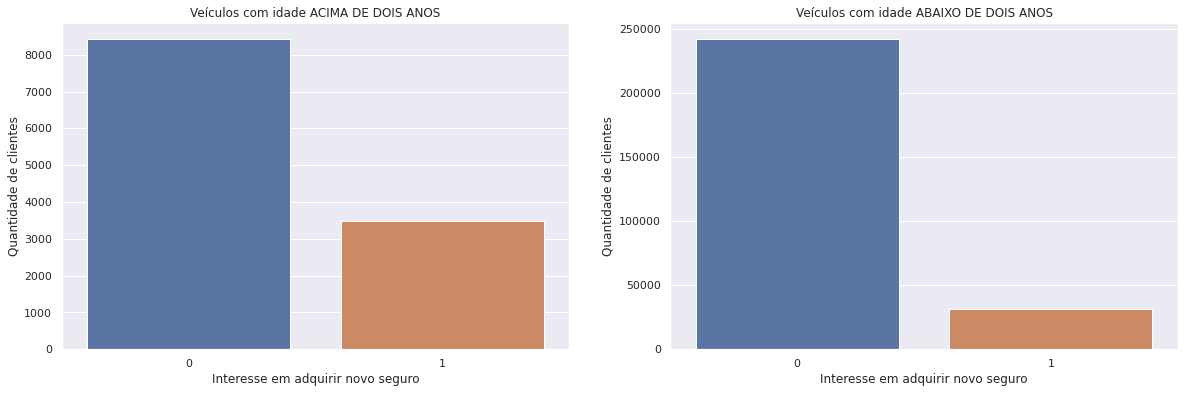

In [41]:
# auxiliar dataframes
aux_o = df4[df4["vehicle_age"] == "over_two_years"].groupby("response").count()
aux_1 = df4[df4["vehicle_age"] != "over_two_years"].groupby("response").count()

# plots
plt.figure(figsize=[20,6])
plt.subplot(1,2,1)
sns.barplot(x=aux_o.index,y="vehicle_damage", data=aux_o).set_title('Veículos com idade ACIMA DE DOIS ANOS')
plt.xlabel("Interesse em adquirir novo seguro")
plt.ylabel("Quantidade de clientes")
plt.subplot(1,2,2)
sns.barplot(x=aux_o.index,y="vehicle_damage", data=aux_1).set_title('Veículos com idade ABAIXO DE DOIS ANOS')
plt.xlabel("Interesse em adquirir novo seguro")
plt.ylabel("Quantidade de clientes");

### H3. Customers who pay more for insurance annually have less interest in purchasing another

In [42]:
h3 = df4[['annual_premium','response']].groupby('annual_premium').sum().reset_index()

bins = list(np.arange(1000,80000,2000))
h3['annual_premium_binned'] = pd.cut( h3['annual_premium'], bins=bins)
h3b = h3[['annual_premium_binned','response']].groupby('annual_premium_binned').sum().reset_index()

sns.barplot(x='annual_premium_binned',y='response',data=h3b);
plt.xlabel("Annual premium amount paid (binned)");
plt.ylabel("Number of customers interested");
plt.xticks(rotation=90);

### H4. Insurance for women is more expensive on average than for men
* FALSE

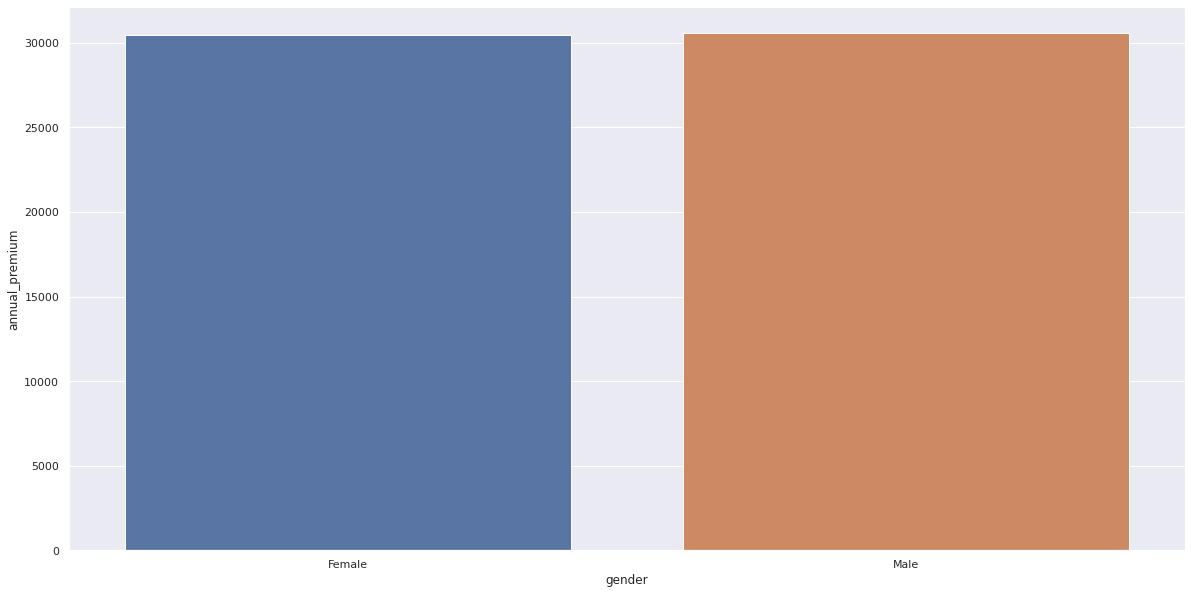

In [43]:
h4 = df4[['gender','annual_premium']].groupby('gender').mean().reset_index()
sns.barplot( x='gender', y='annual_premium', data=h4);

### H5. Older customers are more interested in "cross-selling"
* FALSE

In [44]:
h5 = df4[['vintage','response']].groupby('vintage').sum().reset_index()

bins = list(np.arange(0,300,30))
h5['vintage_binned'] = pd.cut( h5['vintage'], bins=bins)
h5b = h5[['vintage_binned','response']].groupby('vintage_binned').sum().reset_index()

sns.barplot(x='vintage_binned',y='response',data=h5b);
plt.xticks(rotation=90);

## Multivariate analysis

In [45]:
sns.heatmap(df4.corr(), annot=True)
plt.show()

# DATA PREPARATION

In [46]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.20)

df5 = pd.concat([x_train, y_train], axis=1)

In [47]:
df5

id  gender  age  region_code  policy_sales_channel  driving_license        vehicle_age  vehicle_damage  previously_insured  annual_premium  vintage  response
333685  333686  Female   30         28.0                  26.0                1  between_1_2_years               1                   0         34503.0       75         0
299255  299256  Female   22         30.0                 152.0                1       below_1_year               0                   1         36366.0       23         0
140451  140452  Female   25          3.0                  26.0                1       below_1_year               1                   0         22405.0      256         0
379735  379736  Female   23         28.0                 152.0                1       below_1_year               1                   0         46392.0       78         0
256820  256821    Male   68          8.0                 124.0                1     over_two_years               1                   0         45118.0      250         1
...        ...     ...  ...          ...                   ...              ...                ...             ...                 ...             ...      ...       ...
159332  159333  Female   39          4.0                 155.0                1  between_1_2_years               1                   0          2630.0      196         0
10690    10691  Female   23         33.0                 152.0                1       below_1_year               0                   1         53170.0      291         0
123984  123985  Female   26         21.0                 152.0                1       below_1_year               0                   1         26181.0      121         0
44652    44653  Female   46         32.0                  26.0                1  between_1_2_years               1                   0         34215.0      213         0
250839  250840    Male   75         28.0                  25.0                1  between_1_2_years               0                   1         62850.0      268         0

[228664 rows x 12 columns]

## Standardization

In [48]:
ss = pp.StandardScaler()

In [49]:
# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open('../src/features/annual_premium.pkl', 'wb'))

## Rescaling

In [50]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

In [51]:
## age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open('../src/features/age.pkl','wb'))
# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(mms_vintage, open('../src/features/vintage.pkl','wb'))

## Encode

In [52]:
le = pp.LabelEncoder()

In [53]:
# gender 
df5["gender"] = le.fit_transform(df5[["gender"]].values)
pickle.dump(le, open('../src/features/te_gender.pkl','wb'))

# region_code - Target Encoding | F Encondign (Quando houve mais de 6 opções)
te_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(te_region_code)
pickle.dump(te_region_code, open('../src/features/te_region_code.pkl','wb'))

# vehicle_age - Order encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - frequency Encoding
fe_policy_sales = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales)
pickle.dump(fe_policy_sales, open('../src/features/fe_policy_sales.pkl','wb'))

In [54]:
df5

id  gender       age  region_code  policy_sales_channel  driving_license  vehicle_damage  previously_insured  annual_premium   vintage  response  vehicle_age_below_1_year  vehicle_age_between_1_2_years  vehicle_age_over_two_years
333685  333686       0  0.153846     0.186924              0.208664                1               1                   0        0.226789  0.224913         0                         0                              1                           0
299255  299256       0  0.030769     0.072511              0.354538                1               0                   1        0.334573  0.044983         0                         1                              0                           0
140451  140452       0  0.076923     0.129477              0.208664                1               1                   0       -0.473149  0.851211         0                         1                              0                           0
379735  379736       0  0.046154     0.186924              0.354538                1               1                   0        0.914634  0.235294         0                         1                              0                           0
256820  256821       1  0.738462     0.096548              0.194180                1               1                   0        0.840926  0.830450         1                         0                              0                           1
...        ...     ...       ...          ...                   ...              ...             ...                 ...             ...       ...       ...                       ...                            ...                         ...
159332  159333       0  0.292308     0.170433              0.003297                1               1                   0       -1.617243  0.643599         0                         0                              1                           0
10690    10691       0  0.046154     0.097237              0.354538                1               0                   1        1.306779  0.972318         0                         1                              0                           0
123984  123985       0  0.092308     0.071236              0.354538                1               0                   1       -0.254686  0.384083         0                         1                              0                           0
44652    44653       0  0.400000     0.084685              0.208664                1               1                   0        0.210126  0.702422         0                         0                              1                           0
250839  250840       1  0.846154     0.186924              0.004894                1               0                   1        1.866821  0.892734         0                         0                              1                           0

[228664 rows x 14 columns]

## Validation preparation

In [55]:
# gender
x_validation['gender'] = le.fit_transform(x_validation['gender'])

# annual
x_validation['annual_premium'] = ss.fit_transform(x_validation[['annual_premium']].values)

# age
x_validation.loc[:,'age'] = mms_age.fit_transform(x_validation[['age']].values)

# vintage
x_validation.loc[:,'vintage'] = mms_vintage.fit_transform(x_validation[['vintage']].values)

# region code
x_validation.loc[:, 'region_code'] = x_validation.loc[:,'region_code'].map(te_region_code)

# vehicle_age
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales)

#fillna
x_validation = x_validation.fillna(0)

# FEATURE SELECTION

## Feature Importance

In [56]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=-1)

#data preparation
x_train_n = df5.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_jobs=-1, random_state=0)

In [57]:
importances = forest.feature_importances_

# ordena as features mais importantes
df=pd.DataFrame()
for i,j in zip(x_train_n, importances):
    aux = pd.DataFrame( {'feature':i, 'importance':j}, index=[0])
    df = pd.concat([df,aux],axis=0)
    
df = df.sort_values('importance', ascending=False)

In [58]:
sns.barplot(x="importance", y="feature", data=df);

In [59]:
# features selecionadas para treinar os modelos
cols_selected = ['age', 'region_code', 'policy_sales_channel','previously_insured',
                 'annual_premium', 'vintage',"vehicle_damage"]

# MACHINE LEARNING MODEL

In [60]:
x_train_feat = df5[ cols_selected ]
x_validation_feat = x_validation[ cols_selected ]

## KNN

In [61]:
#model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# model traing
knn_model.fit(x_train_feat, y_train)

# predict - Generalização
yhat_knn = knn_model.predict_proba(x_validation_feat)

# gráficos
plt.figure(figsize=[20,5])
ax1 = plt.subplot(1,2,1)
skplt.metrics.plot_cumulative_gain(y_validation,yhat_knn, ax=ax1)
ax2 = plt.subplot(1,2,2)
skplt.metrics.plot_lift_curve(y_validation,yhat_knn, ax=ax2)
plt.show()

### Cross Validation KNN

In [62]:
cv_knn = cross_validation(knn_model, "KNN", x_train_feat, y_train, 5)
cv_knn

Model  Precision@k_CV    CV_STD  Recall@k_CV  CV_STD_Recall
0   KNN        0.226599  0.001361     0.810103       0.004885

## Extra trees

In [63]:
# model definition
et = en.ExtraTreesClassifier(n_estimators=100, n_jobs=-1,
                             random_state=42)

# model fit
et.fit(x_train_feat,y_train)

# model predict
yhat_et = et.predict_proba(x_validation_feat)

# acumulativa gain EXTRATREES
plt.figure(figsize=[20,5])
ax1 = plt.subplot(1,2,1)
skplt.metrics.plot_cumulative_gain(y_validation,yhat_et, ax=ax1)
ax2 = plt.subplot(1,2,2)
skplt.metrics.plot_lift_curve(y_validation,yhat_et, ax=ax2)
plt.show()

### Cross Validation ExtraTree

In [64]:
cv_et = cross_validation(et, "Extra Tree", x_train_feat, y_train, 5)
cv_et

Model  Precision@k_CV    CV_STD  Recall@k_CV  CV_STD_Recall
0  Extra Tree        0.259077  0.000769     0.926215       0.002826

## Logistic Regression

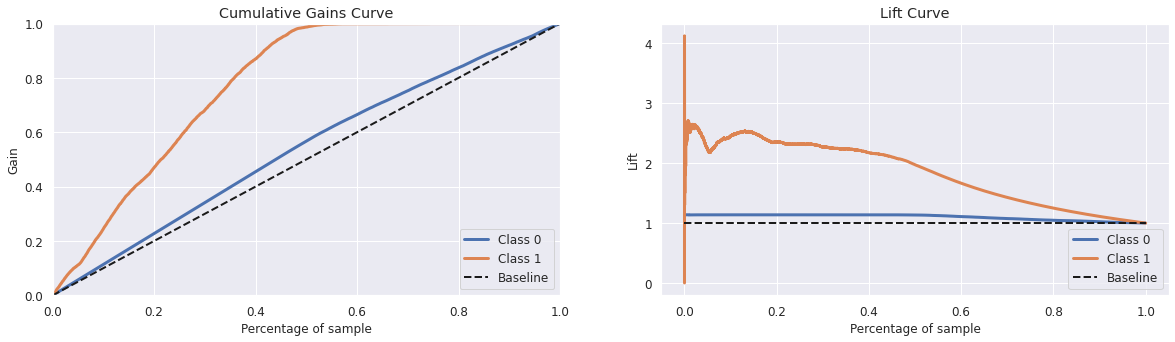

In [65]:
# model definition
lr = LogisticRegression(n_jobs=-1,random_state=42)

# model fit
lr.fit(x_train_feat,y_train)

# model predict
yhat_lr = lr.predict_proba(x_validation_feat)

# gráficos
plt.figure(figsize=[20,5])
ax1 = plt.subplot(1,2,1)
skplt.metrics.plot_cumulative_gain(y_validation,yhat_lr, ax=ax1)
ax2 = plt.subplot(1,2,2)
skplt.metrics.plot_lift_curve(y_validation,yhat_lr, ax=ax2)
plt.show()

### Cross Validation LogisticRegression

In [66]:
cv_lr = cross_validation(lr, "Logistic Regression", x_train_feat, y_train, 5)
cv_lr

Model  Precision@k_CV    CV_STD  Recall@k_CV  CV_STD_Recall
0  Logistic Regression        0.260557  0.000643     0.931506       0.002362

## LGBM

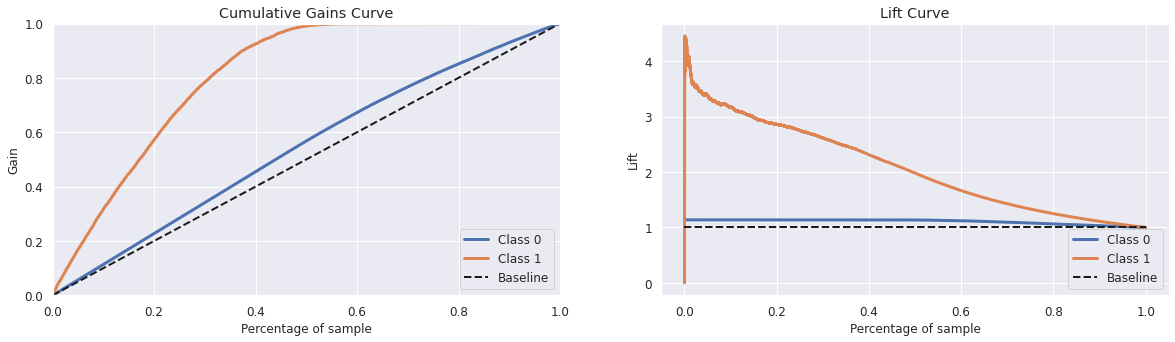

In [67]:
# model definition
lgbm_model = LGBMClassifier(n_jobs =-1, max_depth=10)

# model fit
lgbm_model.fit( x_train_feat, y_train )

# model prediction
yhat_lgbm = lgbm_model.predict_proba( x_validation_feat )

# gráficos
plt.figure(figsize=[20,5])
ax1 = plt.subplot(1,2,1)
skplt.metrics.plot_cumulative_gain(y_validation,yhat_lgbm, ax=ax1)
ax2 = plt.subplot(1,2,2)
skplt.metrics.plot_lift_curve(y_validation,yhat_lgbm, ax=ax2)
plt.show()

### Cross Validation LGBM

In [68]:
cv_lgbm = cross_validation(lgbm_model, "LGBM", x_train_feat, y_train, 5)
cv_lgbm

Model  Precision@k_CV    CV_STD  Recall@k_CV  CV_STD_Recall
0  LGBM        0.267287  0.000499     0.955564       0.001863

###  Compare model's performance Cross Validation

In [69]:
modelling_result_cv = pd.concat([cv_lr,cv_et, cv_knn, cv_lgbm])
modelling_result_cv.sort_values('Precision@k_CV', ascending=False)

Model  Precision@k_CV    CV_STD  Recall@k_CV  CV_STD_Recall
0                 LGBM        0.267287  0.000499     0.955564       0.001863
0  Logistic Regression        0.260557  0.000643     0.931506       0.002362
0           Extra Tree        0.259077  0.000769     0.926215       0.002826
0                  KNN        0.226599  0.001361     0.810103       0.004885

# HYPERPARAMETER FINE TUNING

In [70]:
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

In [71]:
MAX_EVAL = 10

lgbm_parameter = {'num_leaves': (5,15,45,60,90),
                  'max_depth': (5, 7, 10 ),
                  'min_split_gain': (0.001, 0.01 ,0.1),
                  'min_child_weight': (10,30,40,50),
                  'subsample':(0.5, 1),
                  'colsample_bytree':(0.1, 1)
                 }

In [72]:
# dataframe to save model's precision@k
precision_metrics = pd.DataFrame(columns=['Model', 'Precision@k', 'Recall@k'])
final_result = pd.DataFrame()

# size of true values from target validation dataset
k_size = 20000

for i in range( MAX_EVAL):
    
    # choose values for parameters randomly
    hp = {k: rd.sample( v, 1)[0]for k, v in lgbm_parameter.items() }
    print( hp )
    
    # model
    lgbm = LGBMClassifier(num_leaves=hp['num_leaves'],
                                  max_depth=hp['max_depth'],
                                  min_split_gain=hp['min_split_gain'],
                                  min_child_weight=hp['min_child_weight'],
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'])

    # performance
    cros_v = cross_validation(lgbm, "LGBM", x_train_feat, y_train, 5, k=k_size)
    final_result = pd.concat([final_result, cros_v])

final_result

{'num_leaves': 60, 'max_depth': 10, 'min_split_gain': 0.1, 'min_child_weight': 30, 'subsample': 0.5, 'colsample_bytree': 1}
{'num_leaves': 45, 'max_depth': 7, 'min_split_gain': 0.001, 'min_child_weight': 30, 'subsample': 1, 'colsample_bytree': 1}
{'num_leaves': 45, 'max_depth': 5, 'min_split_gain': 0.001, 'min_child_weight': 10, 'subsample': 0.5, 'colsample_bytree': 0.1}
{'num_leaves': 15, 'max_depth': 5, 'min_split_gain': 0.1, 'min_child_weight': 50, 'subsample': 1, 'colsample_bytree': 0.1}
{'num_leaves': 15, 'max_depth': 7, 'min_split_gain': 0.01, 'min_child_weight': 10, 'subsample': 0.5, 'colsample_bytree': 1}
{'num_leaves': 90, 'max_depth': 5, 'min_split_gain': 0.001, 'min_child_weight': 50, 'subsample': 1, 'colsample_bytree': 0.1}
{'num_leaves': 60, 'max_depth': 7, 'min_split_gain': 0.01, 'min_child_weight': 40, 'subsample': 1, 'colsample_bytree': 0.1}
{'num_leaves': 5, 'max_depth': 10, 'min_split_gain': 0.1, 'min_child_weight': 10, 'subsample': 0.5, 'colsample_bytree': 0.1}
{'num

Model  Precision@k_CV    CV_STD  Recall@k_CV  CV_STD_Recall
0  LGBM        0.267217  0.000485     0.955314       0.001788
0  LGBM        0.267157  0.000717     0.955100       0.002613
0  LGBM        0.266547  0.001188     0.952919       0.004194
0  LGBM        0.266707  0.000451     0.953491       0.001562
0  LGBM        0.267617  0.000747     0.956744       0.002589
0  LGBM        0.266687  0.000654     0.953419       0.002309
0  LGBM        0.266627  0.000639     0.953205       0.002211
0  LGBM        0.266197  0.000384     0.951668       0.001369
0  LGBM        0.266987  0.000607     0.954492       0.002136
0  LGBM        0.266767  0.000811     0.953705       0.002939

## Final Model tuned

In [73]:
# parameters tuned
lgbm_parameter = {'num_leaves': 90,
                  'max_depth': 5,
                  'min_split_gain':0.001,
                  'min_child_weight': 40,
                  'subsample':0.5,
                  'colsample_bytree':1
                 }

# create model
lgbm = LGBMClassifier(num_leaves=lgbm_parameter['num_leaves'],
                                  max_depth=lgbm_parameter['max_depth'],
                                  min_split_gain=lgbm_parameter['min_split_gain'],
                                  min_child_weight=lgbm_parameter['min_child_weight'],
                                  subsample=lgbm_parameter['subsample'],
                                  colsample_bytree=lgbm_parameter['colsample_bytree'])

# train model
lgbm = lgbm.fit(x_train_feat, y_train)

# predict
yhat_lgbm = lgbm.predict_proba(x_validation_feat)

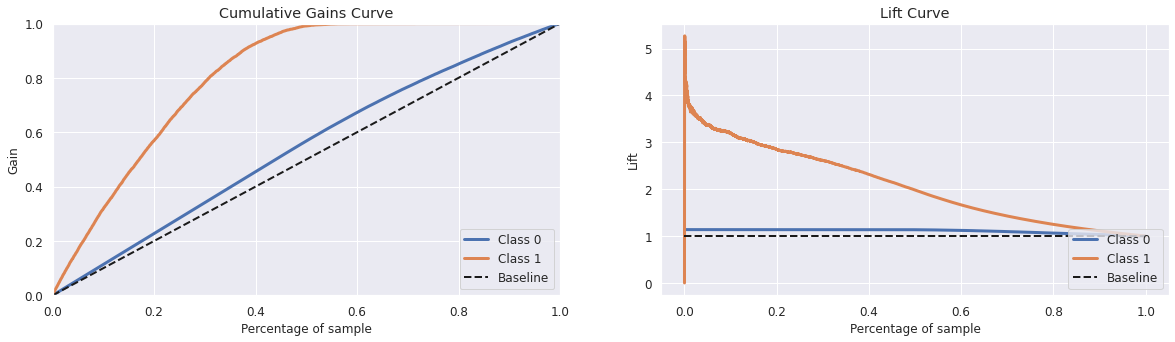

In [74]:
plt.figure(figsize=[20,5])
ax1 = plt.subplot(1,2,1)
skplt.metrics.plot_cumulative_gain(y_validation,yhat_lgbm, ax=ax1)
ax2 = plt.subplot(1,2,2)
skplt.metrics.plot_lift_curve(y_validation,yhat_lgbm, ax=ax2)
plt.show()

## Save model final

In [75]:
# save model final
pickle.dump(lgbm, open('../src/models/lgbm_model.pkl','wb'))

# MODELS PERFORMANCE

## Precision K e Recall K - validation

In [76]:
# copy data
df8 = x_validation_feat.copy()

In [77]:
model = pickle.load(open('../src/models/lgbm_model.pkl','rb'))
yhat_lgbm = model.predict_proba(x_validation_feat)

### At 20000

In [78]:
# response
df8['response'] = y_validation.copy()

# propense score
df8['score'] = yhat_lgbm[:,1].tolist()

# sorted
df8 = df8.sort_values(by='score', ascending=False)

# competiion precision k
precision_at_20000 = precision_at_k(df8,k=20000)
print('Precision at k: {}'.format(precision_at_20000))

# competiion recall k
recall_at_20000 = recall_at_k(df8,k=20000)
print('Recall at k: {}'.format(recall_at_20000))

Precision at k: 0.29958502074896254
Recall at k: 0.8648960739030023


### At 40000

In [79]:
# response
df8['response'] = y_validation.copy()

# propense score
df8['score'] = yhat_lgbm[:,1].tolist()

# sorted
df8 = df8.sort_values(by='score', ascending=False)

# competiion precision k
precision_at_40000 = precision_at_k(df8,k=40000)
print('Precision at k: {}'.format(precision_at_40000))

# competiion recall k
recall_at_40000 = recall_at_k(df8,k=40000)
print('Recall at k: {}'.format(recall_at_40000))

Precision at k: 0.12114697132571686
Recall at k: 0.6994803695150116


# BUSINESS PERFORMANCE

## Analyzing new customers

In [80]:
# load data into feather to use in the project
df_insurance127 = pd.read_feather("../data/raw/test.feather")

### Data before going through the api

In [81]:
df_insurance127.head()

id Gender  Age  Driving_License  Region_Code  Previously_Insured Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage
0  381110   Male   25                1         11.0                   1    < 1 Year             No         35786.0                 152.0       53
1  381111   Male   40                1         28.0                   0    1-2 Year            Yes         33762.0                   7.0      111
2  381112   Male   47                1         28.0                   0    1-2 Year            Yes         40050.0                 124.0      199
3  381113   Male   24                1         27.0                   1    < 1 Year            Yes         37356.0                 152.0      187
4  381114   Male   27                1         28.0                   1    < 1 Year             No         59097.0                 152.0      297

### Passing the data through the api with the model in production

In [82]:
import requests
import json

# converte para json
data = json.dumps(df_insurance127.to_dict(orient='records'))

# API Call
url = 'http://192.168.0.110:5000/predict'
header = {'Content-type' : 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status code: {}'.format(r.status_code))

df1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

Status code: 200


### Data after the API, with the score ordered

In [83]:
df1.sort_values("score", ascending=False).head()

id  Gender  Age  Driving_License  Region_Code  Previously_Insured Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage     score
75775   456885    Male   32                1          1.0                   0    1-2 Year            Yes         43128.0                 124.0      119  0.479184
27309   408419    Male   32                1          1.0                   0    < 1 Year            Yes         44648.0                 124.0       99  0.479184
126974  508084  Female   32                1         35.0                   0    1-2 Year            Yes         26722.0                  26.0      169  0.478607
114342  495452    Male   31                1         35.0                   0    < 1 Year            Yes         23374.0                  26.0      190  0.478607
83196   464306  Female   32                1         35.0                   0    < 1 Year            Yes         30825.0                  26.0      125  0.478607

## Answering business questions

### Main Insights into the most relevant attributes of customers interested in purchasing auto insurance.

 * Customers interested in insurance are over 30 years old and have already had some damage with the car
 * Customers with newer cars (up to two years old) are more interested in purchasing insurance

### What percentage of customers interested in purchasing auto insurance will the sales team be able to contact by making 20,000 calls?

In [84]:
# percentage
pct20000 = round(precision_at_20000 * 100, 2)
qtd_total = round(20000*precision_at_20000, 0)

In [85]:
print(f"With 20,000 calls, the sales team will be able to reach {pct20000}% of interested customers, that is, {qtd_total} customers.")

With 20,000 calls, the sales team will be able to reach 29.96% of interested customers, that is, 5992.0 customers.


### And if the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?

In [86]:
# percentage
pct40000 = round(precision_at_40000 * 100, 2)
qtd_total = round(20000*precision_at_40000, 0)

In [87]:
print(f"With 40,000 calls, the sales team will be able to reach {pct40000}% of interested customers, that is, {qtd_total} customers.")

With 40,000 calls, the sales team will be able to reach 12.11% of interested customers, that is, 2423.0 customers.


# NEXT STEPS

- Better understand the business with the intention of identifying and analyzing new hypotheses
- Check the possibility, based on new knowledge, to develop new features
- Perform new EDA based on the new features
- Test new encoders for the variables
- Use boruta to select relevant features
- Use other classification models and evaluate the results
- Implement new ranking metrics
- Implement the api with docker and CI/CD in gitlab